In [1]:
import pandas as pd
import numpy as np
import supervision as sv
import os
from tqdm.notebook import tqdm

print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"supervision version: {sv.__version__}")

pandas version: 2.3.1
numpy version: 1.26.4
supervision version: 0.26.1


In [2]:
MODEL_NAMES = ['terramind', 'galileo', 'satmae']
CLASS_NAMES = {
    0: "CFCBK",
    1: "FCBK",
    2: "Zigzag"
}
NUM_CLASSES = len(CLASS_NAMES)

# Assumes your notebook and the CSV files are in the same directory
# If not, change this path accordingly
CSV_BASE_PATH = '.' 

# Confidence threshold for including a prediction in the metrics
CONFIDENCE_THRESHOLD = 0.05

In [3]:
def load_detections_from_csv(csv_path: str, confidence_threshold: float = 0.05) -> (list, list):
    """
    Loads ground truth and prediction data from a CSV file into supervision.Detections objects.

    Args:
        csv_path (str): The path to the input CSV file.
        confidence_threshold (float): The minimum score for a prediction to be included.

    Returns:
        A tuple containing two lists:
        - List of supervision.Detections for ground truth.
        - List of supervision.Detections for predictions.
    """
    df = pd.read_csv(csv_path)

    # It's critical to sort the image names to ensure GT and predictions are aligned.
    image_names = sorted(df['image_name'].unique())
    
    targets = []
    predictions = []

    for img_name in tqdm(image_names, desc=f"Processing {os.path.basename(csv_path)}"):
        img_df = df[df['image_name'] == img_name]

        # --- Process Ground Truth ---
        gt_df = img_df[img_df['box_type'] == 'ground_truth']
        if not gt_df.empty:
            gt_boxes = gt_df[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].values
            # Convert 1-based class_id from CSV to 0-based index
            gt_class_ids = (gt_df['class_id'].values - 1).astype(int)
            
            gt_detections = sv.Detections(
                xyxy=gt_boxes,
                class_id=gt_class_ids
            )
        else:
            # Create empty detection object if no ground truth exists for this image
            gt_detections = sv.Detections.empty()
        
        targets.append(gt_detections)

        # --- Process Predictions ---
        pred_df = img_df[img_df['box_type'] == 'prediction']
        # Apply confidence threshold
        pred_df = pred_df[pred_df['confidence_score'] >= confidence_threshold]

        if not pred_df.empty:
            pred_boxes = pred_df[['bbox_xmin', 'bbox_ymin', 'bbox_xmax', 'bbox_ymax']].values
            # Convert 1-based class_id from CSV to 0-based index
            pred_class_ids = (pred_df['class_id'].values - 1).astype(int)
            pred_scores = pred_df['confidence_score'].values

            pred_detections = sv.Detections(
                xyxy=pred_boxes,
                class_id=pred_class_ids,
                confidence=pred_scores
            )
        else:
            # Create empty detection object if no predictions exist for this image
            pred_detections = sv.Detections.empty()
            
        predictions.append(pred_detections)

    return targets, predictions

In [ ]:
all_results = []

# Use the full, explicit import path to avoid ambiguity, as shown in the docs.
from supervision.metrics.mean_average_precision import MeanAveragePrecision

for model_name in MODEL_NAMES:
    print(f"\n--- Evaluating model: {model_name} ---")
    csv_file = os.path.join(CSV_BASE_PATH, f"test_results_{model_name}.csv")
    
    if not os.path.exists(csv_file):
        print(f"Warning: CSV file not found for {model_name} at {csv_file}. Skipping.")
        continue

    # 1. Load data from your CSV
    targets, predictions = load_detections_from_csv(csv_file, confidence_threshold=CONFIDENCE_THRESHOLD)
    
    # 2. Calculate Class-Wise mAP@50
    # We instantiate with class_agnostic=False, as shown in the documentation.
    map_metric_cw = MeanAveragePrecision(class_agnostic=False)
    map_metric_cw.update(predictions=predictions, targets=targets)
    class_wise_results = map_metric_cw.compute()

    # Extract mAP@50 for each class.
    final_class_wise_mAP = [0.0] * NUM_CLASSES
    map_per_class_list = class_wise_results.ap_per_class[:, 0].tolist()
    matched_classes = class_wise_results.matched_classes 
    
    for class_id, map_value in zip(matched_classes, map_per_class_list):
        if class_id < NUM_CLASSES:
             final_class_wise_mAP[class_id] = map_value * 100

    # 3. Calculate Class-Agnostic mAP@50
    # We create a new instance with class_agnostic=True.
    map_metric_ca = MeanAveragePrecision(class_agnostic=True)
    map_metric_ca.update(predictions=predictions, targets=targets)
    class_agnostic_results = map_metric_ca.compute()
    
    # The result object has a '.map50' property for the CA mAP@50 score.
    ca_map_50 = class_agnostic_results.map50 * 100

    # 4. Store the final results
    result_dict = {
        "Model": model_name.capitalize(),
        "CA mAP@50": ca_map_50,
        f"{CLASS_NAMES[0]} mAP@50": final_class_wise_mAP[0],
        f"{CLASS_NAMES[1]} mAP@50": final_class_wise_mAP[1],
        f"{CLASS_NAMES[2]} mAP@50": final_class_wise_mAP[2],
    }
    all_results.append(result_dict)

print("\n✅ Evaluation complete for all models.")


--- Evaluating model: terramind ---


Processing test_results_terramind.csv:   0%|          | 0/15590 [00:00<?, ?it/s]


--- Evaluating model: galileo ---


Processing test_results_galileo.csv:   0%|          | 0/15590 [00:00<?, ?it/s]


--- Evaluating model: satmae ---


Processing test_results_satmae.csv:   0%|          | 0/15590 [00:00<?, ?it/s]


✅ Evaluation complete for all models.


In [12]:
# Convert results list to a DataFrame for pretty printing
results_df = pd.DataFrame(all_results)

# --- Display DataFrame ---
print("--- Model Performance Benchmark ---")
display(results_df.round(2))


# --- Display in LaTeX Table Format ---
print("\n--- LaTeX Formatted Output ---")
for _, row in results_df.iterrows():
    model_key = row['Model']
    ca_map_50_val = row['CA mAP@50']
    class_maps = [row[f'{CLASS_NAMES[i]} mAP@50'] for i in range(NUM_CLASSES)]
    
    # Format: Model & CA_mAP & Class1_mAP & Class2_mAP & Class3_mAP \\
    formatted_output = f"{model_key} & {ca_map_50_val:.2f} & " + " & ".join([f"{val:.2f}" for val in class_maps]) + " \\\\"
    print(formatted_output)

--- Model Performance Benchmark ---


,Model,CA mAP@50,CFCBK mAP@50,FCBK mAP@50,Zigzag mAP@50
0,Terramind,85.37,72.75,72.45,76.86
1,Galileo,84.78,71.34,73.08,77.06
2,Satmae,81.55,53.37,59.63,65.06



--- LaTeX Formatted Output ---
Terramind & 85.37 & 72.75 & 72.45 & 76.86 \\
Galileo & 84.78 & 71.34 & 73.08 & 77.06 \\
Satmae & 81.55 & 53.37 & 59.63 & 65.06 \\


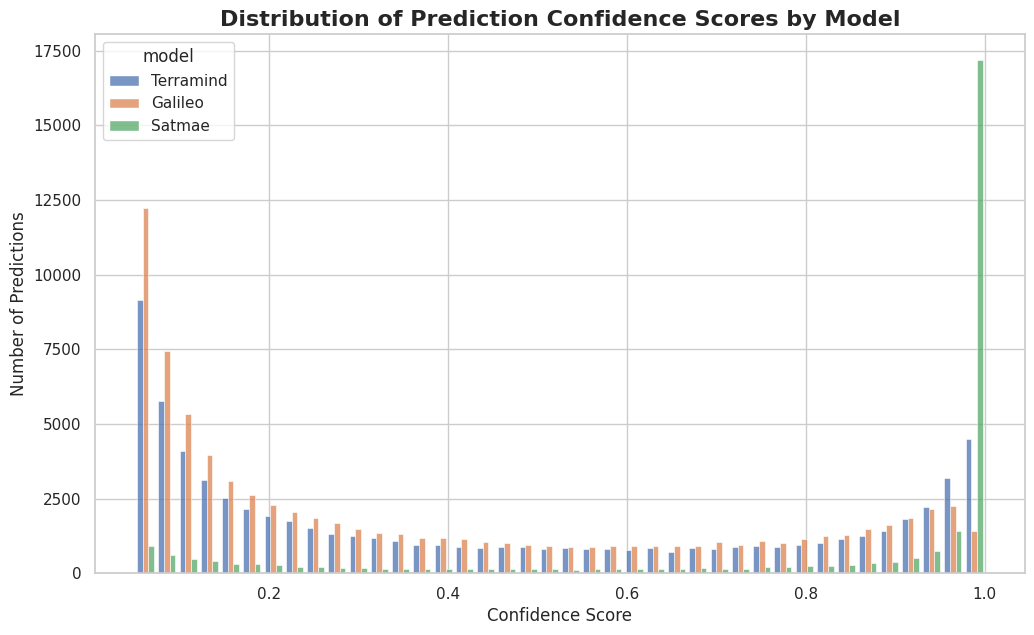

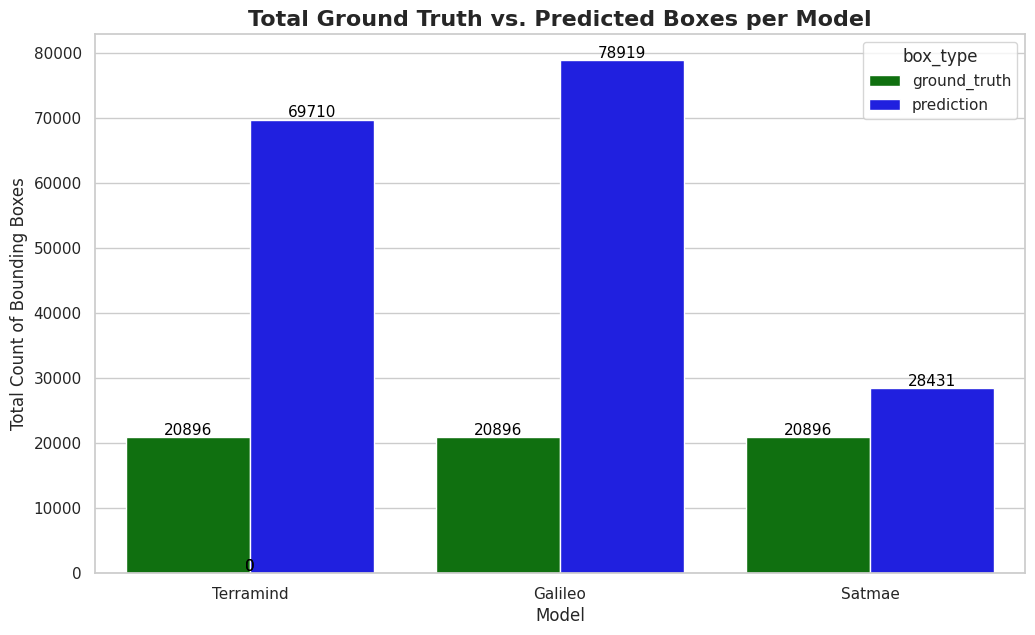

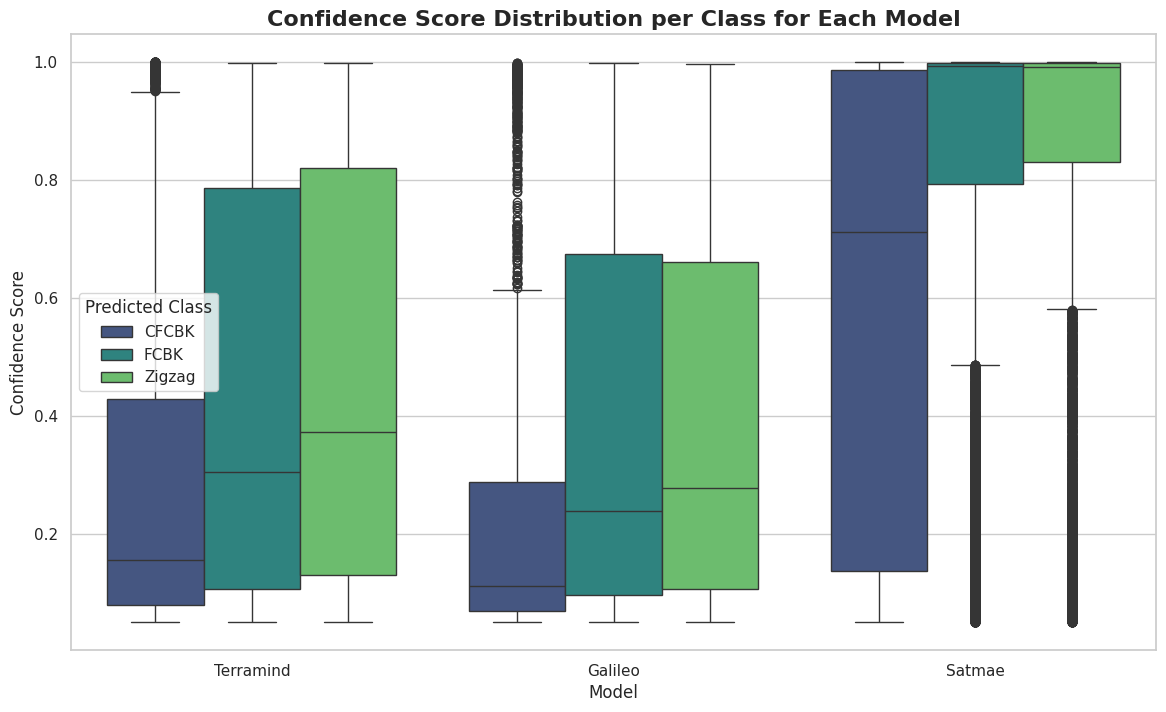

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# --- Configuration ---
MODEL_NAMES = ['terramind', 'galileo', 'satmae']
CSV_BASE_PATH = '.' # Assumes CSVs are in the same directory as the notebook

# --- Load and Combine Data ---
all_dfs = []
for model_name in MODEL_NAMES:
    csv_file = os.path.join(CSV_BASE_PATH, f"test_results_{model_name}.csv")
    if os.path.exists(csv_file):
        df = pd.read_csv(csv_file)
        df['model'] = model_name.capitalize() # Add a column to identify the model
        all_dfs.append(df)
    else:
        print(f"Warning: Could not find {csv_file}")

# Combine into a single DataFrame for easier plotting
combined_df = pd.concat(all_dfs, ignore_index=True)

# Separate predictions from ground truth for analysis
predictions_df = combined_df[combined_df['box_type'] == 'prediction'].copy()
ground_truth_df = combined_df[combined_df['box_type'] == 'ground_truth'].copy()

# --- Analysis Plots ---
sns.set_theme(style="whitegrid")

# 1. Histogram of Prediction Confidence Scores
plt.figure(figsize=(12, 7))
sns.histplot(data=predictions_df, x='confidence_score', hue='model', multiple='dodge', bins=40, shrink=0.8)
plt.title('Distribution of Prediction Confidence Scores by Model', fontsize=16, weight='bold')
plt.xlabel('Confidence Score', fontsize=12)
plt.ylabel('Number of Predictions', fontsize=12)
plt.show()

# 2. Bar Plot of Prediction Counts vs. Ground Truth Counts
plt.figure(figsize=(12, 7))
sns.countplot(data=combined_df, x='model', hue='box_type', palette={'ground_truth': 'green', 'prediction': 'blue'})
plt.title('Total Ground Truth vs. Predicted Boxes per Model', fontsize=16, weight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Total Count of Bounding Boxes', fontsize=12)
# Add text labels on bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                       textcoords='offset points')
plt.show()


# 3. Box Plot of Confidence Scores by Predicted Class
plt.figure(figsize=(14, 8))
# Map class_id to class_name for predictions
predictions_df['class_name'] = predictions_df['class_id'].map({1: 'CFCBK', 2: 'FCBK', 3: 'Zigzag'})
sns.boxplot(data=predictions_df, x='model', y='confidence_score', hue='class_name', palette='viridis')
plt.title('Confidence Score Distribution per Class for Each Model', fontsize=16, weight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Confidence Score', fontsize=12)
plt.legend(title='Predicted Class')
plt.show()

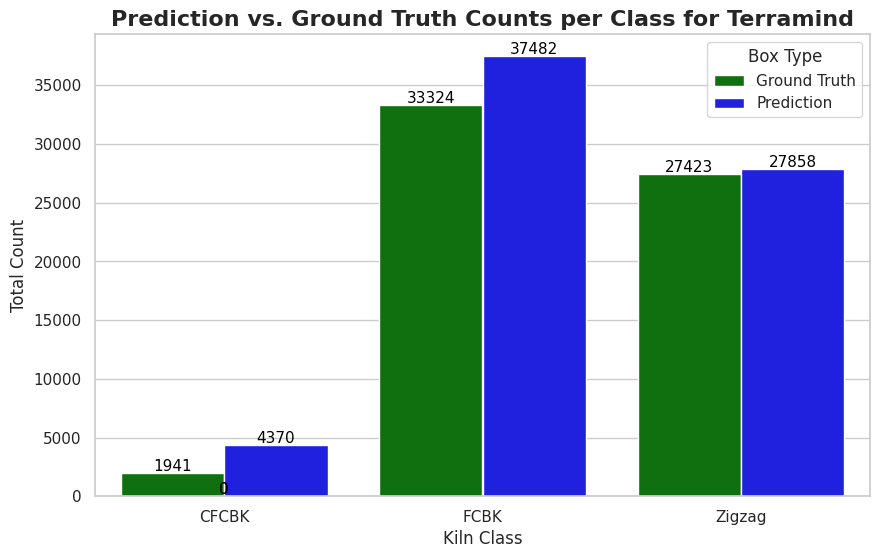

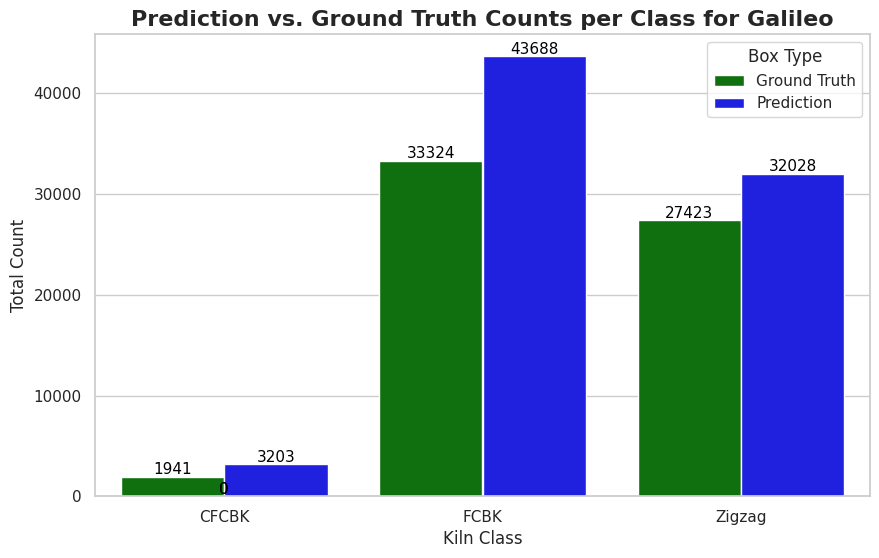

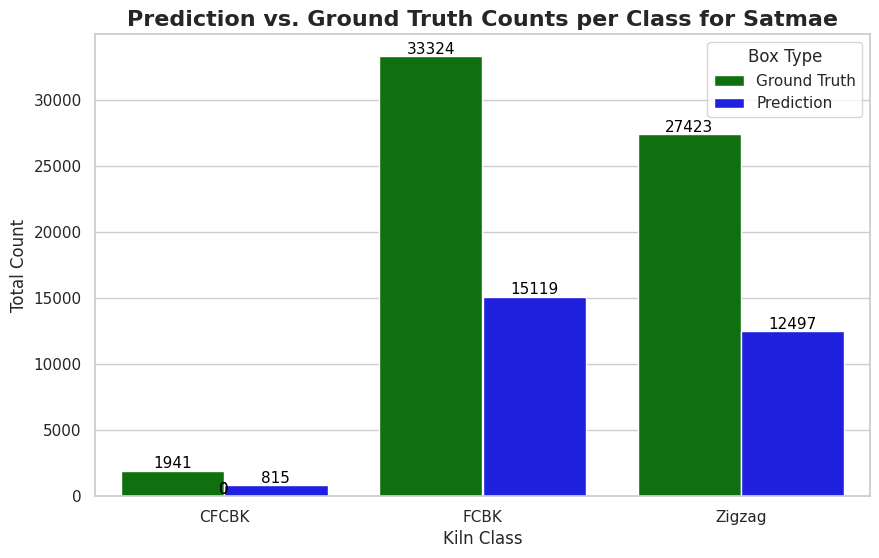

In [15]:
# This cell assumes you have already run Cell 6 to create the 'predictions_df' and 'ground_truth_df'

# --- Plot 4: Class-wise Prediction vs. Ground Truth Counts ---
# We'll create a separate plot for each model for clarity.

for model_name in ['Terramind', 'Galileo', 'Satmae']:
    
    # Filter data for the current model
    model_preds = predictions_df[predictions_df['model'] == model_name]
    
    # Prepare data for plotting
    pred_counts = model_preds['class_name'].value_counts().reset_index()
    pred_counts.columns = ['class_name', 'count']
    pred_counts['type'] = 'Prediction'
    
    gt_counts = ground_truth_df['class_name'].value_counts().reset_index()
    gt_counts.columns = ['class_name', 'count']
    gt_counts['type'] = 'Ground Truth'
    
    plot_data = pd.concat([gt_counts, pred_counts])
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=plot_data, x='class_name', y='count', hue='type', 
                palette={'Ground Truth': 'green', 'Prediction': 'blue'}, 
                order=['CFCBK', 'FCBK', 'Zigzag']) # Ensure consistent class order
    
    plt.title(f'Prediction vs. Ground Truth Counts per Class for {model_name}', fontsize=16, weight='bold')
    plt.xlabel('Kiln Class', fontsize=12)
    plt.ylabel('Total Count', fontsize=12)
    plt.legend(title='Box Type')

    # Add text labels on bars
    for p in plt.gca().patches:
        plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                           ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                           textcoords='offset points')
    
    plt.show()

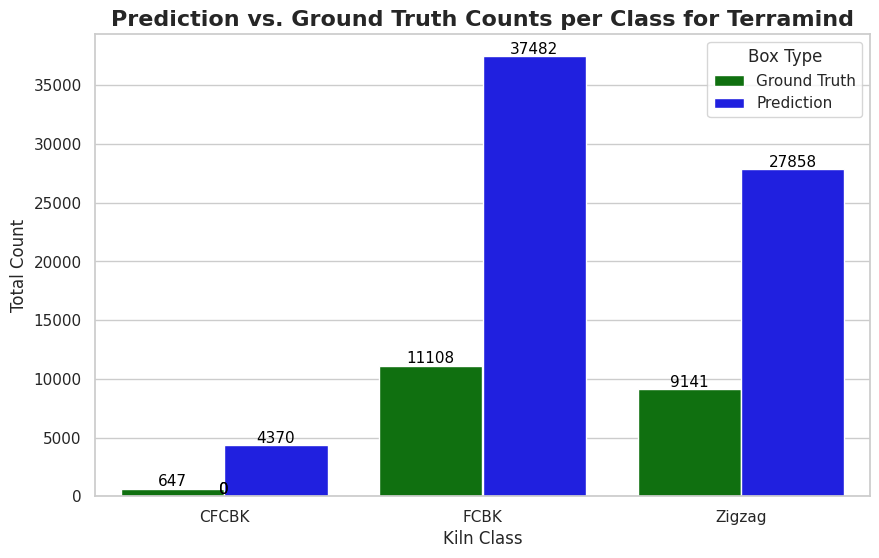

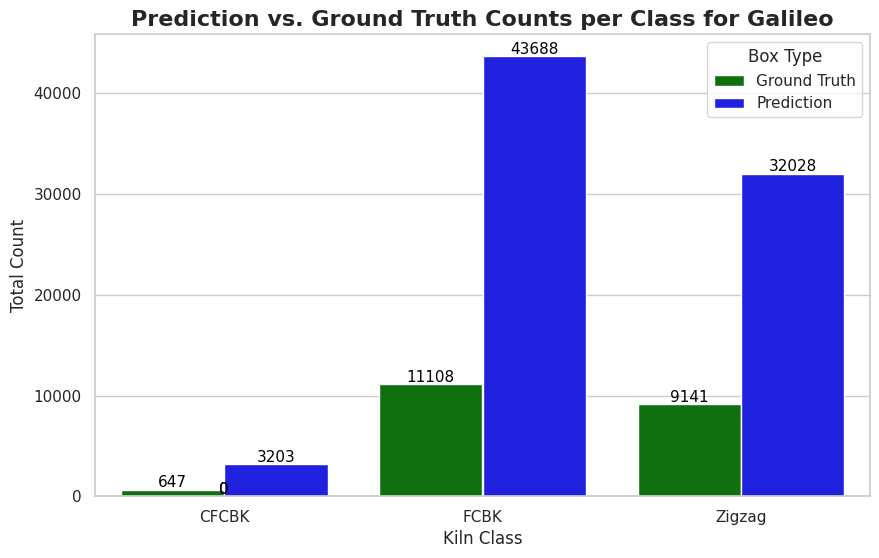

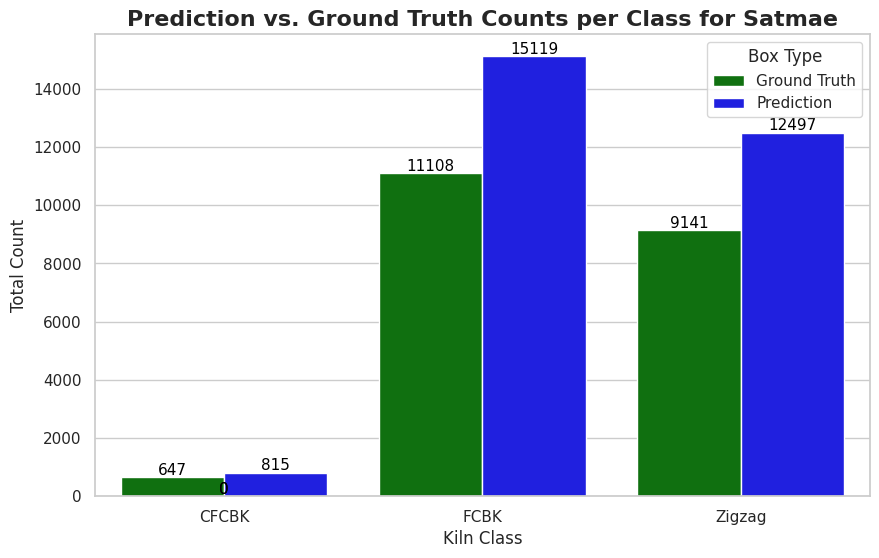

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# --- Configuration ---
MODEL_NAMES = ['terramind', 'galileo', 'satmae']
CSV_BASE_PATH = '.' # Assumes CSVs are in the same directory

# --- Correctly Calculate Ground Truth ONCE ---
# We only need to load one file to get the correct ground truth counts.
try:
    single_df_for_gt = pd.read_csv(os.path.join(CSV_BASE_PATH, 'test_results_terramind.csv'))
    ground_truth_df = single_df_for_gt[single_df_for_gt['box_type'] == 'ground_truth'].copy()
    ground_truth_df['class_name'] = ground_truth_df['class_id'].map({1: 'CFCBK', 2: 'FCBK', 3: 'Zigzag'})
    gt_counts = ground_truth_df['class_name'].value_counts().reset_index()
    gt_counts.columns = ['class_name', 'count']
    gt_counts['type'] = 'Ground Truth'
except FileNotFoundError:
    print("Error: 'test_results_terramind.csv' not found. Cannot calculate ground truth.")
    gt_counts = pd.DataFrame() # Create empty dataframe to avoid crashing the loop

# --- Load All Predictions ---
all_preds_list = []
for model_name in MODEL_NAMES:
    csv_file = os.path.join(CSV_BASE_PATH, f"test_results_{model_name}.csv")
    if os.path.exists(csv_file):
        df = pd.read_csv(csv_file)
        preds = df[df['box_type'] == 'prediction'].copy()
        preds['model'] = model_name.capitalize()
        all_preds_list.append(preds)
all_predictions_df = pd.concat(all_preds_list, ignore_index=True)
all_predictions_df['class_name'] = all_predictions_df['class_id'].map({1: 'CFCBK', 2: 'FCBK', 3: 'Zigzag'})

# --- Loop Through and Plot for Each Model ---
if not gt_counts.empty:
    for model_name_capitalized in ['Terramind', 'Galileo', 'Satmae']:
        
        # Filter predictions for the current model
        model_preds = all_predictions_df[all_predictions_df['model'] == model_name_capitalized]
        
        # Get prediction counts
        pred_counts = model_preds['class_name'].value_counts().reset_index()
        pred_counts.columns = ['class_name', 'count']
        pred_counts['type'] = 'Prediction'
        
        # Combine the SINGLE ground truth with the CURRENT predictions
        plot_data = pd.concat([gt_counts, pred_counts])
        
        # Create the plot
        plt.figure(figsize=(10, 6))
        sns.barplot(data=plot_data, x='class_name', y='count', hue='type', 
                    palette={'Ground Truth': 'green', 'Prediction': 'blue'}, 
                    order=['CFCBK', 'FCBK', 'Zigzag'])
        
        plt.title(f'Prediction vs. Ground Truth Counts per Class for {model_name_capitalized}', fontsize=16, weight='bold')
        plt.xlabel('Kiln Class', fontsize=12)
        plt.ylabel('Total Count', fontsize=12)
        plt.legend(title='Box Type')

        # Add text labels
        for p in plt.gca().patches:
            plt.gca().annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                               ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                               textcoords='offset points')
        
        plt.show()